# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 38)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,tmp1,tmp2,z_i,z_r,z_g,z_u,i_r,i_g,i_u,r_g,r_u,g_u,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ri,d_dered_gi,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_rg,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,1.1898,0.0,-2.9272,-1.3371,-0.7328,-2.0699,-3.3972,-6.3243,-1.3371,-2.6643,-5.5915,-1.3273,-4.2545,-2.9272,2.8665,1.3027,0.7232,1.3230,2.6257,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-1.3027,-4.1691,-2.8665,1.0000
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.2533,1.0,-0.9902,-0.1840,-0.0995,-0.2835,-0.8930,-1.8832,-0.1840,-0.7935,-1.7837,-0.6096,-1.5997,-0.9902,0.9619,0.5931,0.1016,0.1751,0.7683,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-0.5931,-1.5550,-0.9619,1.0000
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,1.0225,0.0,-0.9610,-0.1428,-0.0435,-0.1863,-0.4754,-1.4364,-0.1428,-0.4319,-1.3928,-0.2891,-1.2501,-0.9610,0.9211,0.2466,0.0257,0.1183,0.3649,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-0.2466,-1.1676,-0.9211,1.0000
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,1.2054,0.0,-4.4719,-0.3262,-0.2603,-0.5865,-1.5541,-6.0260,-0.3262,-1.2938,-5.7657,-0.9676,-5.4395,-4.4719,4.3590,0.9074,0.2395,0.2926,1.2000,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-0.9074,-5.2664,-4.3590,0.7500
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,1.1939,0.0,-3.7543,-0.7182,-0.3415,-1.0597,-2.7165,-6.4708,-0.7182,-2.3750,-6.1293,-1.6568,-5.4111,-3.7543,3.3376,1.5709,0.3144,0.6727,2.2436,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-1.5709,-4.9084,-3.3376,0.9231


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 37) (80000, 37)


## Hyperparameter Tuning

In [22]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.3, random_state=seed)

In [23]:
params = {
    "objective": "multiclass",
    "n_estimators": 3000,
    "subsample_freq": 1,
    "random_state": 0,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.4)),
    "num_leaves": hp.choice("num_leaves", [32, 64,78 ,128, 256]),
    "colsample_bytree": hp.quniform("colsample_bytree", .3, 1., 0.1),
    "subsample": hp.quniform("subsample", .4, 1., 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100, 250])
}

In [24]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.28s/trial, best loss: 0.1572772575734877]
{'objective': 'multiclass', 'n_estimators': 3000, 'subsample_freq': 1, 'random_state': 0, 'n_jobs': -1, 'colsample_bytree': 0.9, 'learning_rate': 0.014978022514224204, 'min_child_samples': 25, 'num_leaves': 128, 'subsample': 0.5}


## Stratified K-Fold Cross Validation

In [25]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

## LightGBM 모델 학습

In [26]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=30)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.964127
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.942025
[3]	valid_0's multi_logloss: 0.920935
[4]	valid_0's multi_logloss: 0.900601
[5]	valid_0's multi_logloss: 0.882476
[6]	valid_0's multi_logloss: 0.864631
[7]	valid_0's multi_logloss: 0.846436
[8]	valid_0's multi_logloss: 0.828876
[9]	valid_0's multi_logloss: 0.811909
[10]	valid_0's multi_logloss: 0.795539
[11]	valid_0's multi_logloss: 0.780236
[12]	valid_0's multi_logloss: 0.764937
[13]	valid_0's multi_logloss: 0.750423
[14]	valid_0's multi_logloss: 0.735997
[15]	valid_0's multi_logloss: 0.722034
[16]	valid_0's multi_logloss: 0.708516
[17]	valid_0's multi_logloss: 0.695405
[18]	valid_0's multi_logloss: 0.682707
[19]	valid_0's multi_logloss: 0.670368
[20]	valid_0's multi_logloss: 0.658411
[21]	valid_0's multi_logloss: 0.646799
[22]	valid_0's multi_logloss: 0.635532
[23]	valid_0's multi_logloss: 0.624568
[24]	valid_0's multi_loglo

[210]	valid_0's multi_logloss: 0.172626
[211]	valid_0's multi_logloss: 0.172361
[212]	valid_0's multi_logloss: 0.172145
[213]	valid_0's multi_logloss: 0.171929
[214]	valid_0's multi_logloss: 0.171687
[215]	valid_0's multi_logloss: 0.17145
[216]	valid_0's multi_logloss: 0.171196
[217]	valid_0's multi_logloss: 0.17095
[218]	valid_0's multi_logloss: 0.170727
[219]	valid_0's multi_logloss: 0.170512
[220]	valid_0's multi_logloss: 0.170287
[221]	valid_0's multi_logloss: 0.170053
[222]	valid_0's multi_logloss: 0.169824
[223]	valid_0's multi_logloss: 0.169606
[224]	valid_0's multi_logloss: 0.169401
[225]	valid_0's multi_logloss: 0.169183
[226]	valid_0's multi_logloss: 0.168984
[227]	valid_0's multi_logloss: 0.16877
[228]	valid_0's multi_logloss: 0.168567
[229]	valid_0's multi_logloss: 0.168396
[230]	valid_0's multi_logloss: 0.168201
[231]	valid_0's multi_logloss: 0.168007
[232]	valid_0's multi_logloss: 0.167807
[233]	valid_0's multi_logloss: 0.167652
[234]	valid_0's multi_logloss: 0.167473
[23

[415]	valid_0's multi_logloss: 0.155365
[416]	valid_0's multi_logloss: 0.155334
[417]	valid_0's multi_logloss: 0.155315
[418]	valid_0's multi_logloss: 0.15529
[419]	valid_0's multi_logloss: 0.155264
[420]	valid_0's multi_logloss: 0.155237
[421]	valid_0's multi_logloss: 0.155219
[422]	valid_0's multi_logloss: 0.155196
[423]	valid_0's multi_logloss: 0.155181
[424]	valid_0's multi_logloss: 0.155161
[425]	valid_0's multi_logloss: 0.155146
[426]	valid_0's multi_logloss: 0.155126
[427]	valid_0's multi_logloss: 0.155105
[428]	valid_0's multi_logloss: 0.155094
[429]	valid_0's multi_logloss: 0.155081
[430]	valid_0's multi_logloss: 0.155062
[431]	valid_0's multi_logloss: 0.155046
[432]	valid_0's multi_logloss: 0.15503
[433]	valid_0's multi_logloss: 0.155001
[434]	valid_0's multi_logloss: 0.154975
[435]	valid_0's multi_logloss: 0.154953
[436]	valid_0's multi_logloss: 0.154938
[437]	valid_0's multi_logloss: 0.154927
[438]	valid_0's multi_logloss: 0.154915
[439]	valid_0's multi_logloss: 0.154895
[4

[622]	valid_0's multi_logloss: 0.153491
[623]	valid_0's multi_logloss: 0.153493
[624]	valid_0's multi_logloss: 0.1535
[625]	valid_0's multi_logloss: 0.153498
[626]	valid_0's multi_logloss: 0.153497
[627]	valid_0's multi_logloss: 0.153487
[628]	valid_0's multi_logloss: 0.15348
[629]	valid_0's multi_logloss: 0.153478
[630]	valid_0's multi_logloss: 0.153475
[631]	valid_0's multi_logloss: 0.153473
[632]	valid_0's multi_logloss: 0.153461
[633]	valid_0's multi_logloss: 0.153458
[634]	valid_0's multi_logloss: 0.153457
[635]	valid_0's multi_logloss: 0.153445
[636]	valid_0's multi_logloss: 0.153448
[637]	valid_0's multi_logloss: 0.153441
[638]	valid_0's multi_logloss: 0.153436
[639]	valid_0's multi_logloss: 0.153434
[640]	valid_0's multi_logloss: 0.153437
[641]	valid_0's multi_logloss: 0.15344
[642]	valid_0's multi_logloss: 0.153441
[643]	valid_0's multi_logloss: 0.153428
[644]	valid_0's multi_logloss: 0.153425
[645]	valid_0's multi_logloss: 0.15342
[646]	valid_0's multi_logloss: 0.153408
[647]

[28]	valid_0's multi_logloss: 0.574029
[29]	valid_0's multi_logloss: 0.564752
[30]	valid_0's multi_logloss: 0.556069
[31]	valid_0's multi_logloss: 0.547299
[32]	valid_0's multi_logloss: 0.53876
[33]	valid_0's multi_logloss: 0.530402
[34]	valid_0's multi_logloss: 0.522573
[35]	valid_0's multi_logloss: 0.514671
[36]	valid_0's multi_logloss: 0.506978
[37]	valid_0's multi_logloss: 0.499469
[38]	valid_0's multi_logloss: 0.492451
[39]	valid_0's multi_logloss: 0.485589
[40]	valid_0's multi_logloss: 0.478618
[41]	valid_0's multi_logloss: 0.47184
[42]	valid_0's multi_logloss: 0.465208
[43]	valid_0's multi_logloss: 0.458865
[44]	valid_0's multi_logloss: 0.452546
[45]	valid_0's multi_logloss: 0.446373
[46]	valid_0's multi_logloss: 0.440363
[47]	valid_0's multi_logloss: 0.4345
[48]	valid_0's multi_logloss: 0.428744
[49]	valid_0's multi_logloss: 0.423139
[50]	valid_0's multi_logloss: 0.417881
[51]	valid_0's multi_logloss: 0.412822
[52]	valid_0's multi_logloss: 0.407801
[53]	valid_0's multi_logloss:

[238]	valid_0's multi_logloss: 0.166762
[239]	valid_0's multi_logloss: 0.166593
[240]	valid_0's multi_logloss: 0.16642
[241]	valid_0's multi_logloss: 0.166279
[242]	valid_0's multi_logloss: 0.166125
[243]	valid_0's multi_logloss: 0.165955
[244]	valid_0's multi_logloss: 0.165802
[245]	valid_0's multi_logloss: 0.16566
[246]	valid_0's multi_logloss: 0.165508
[247]	valid_0's multi_logloss: 0.165349
[248]	valid_0's multi_logloss: 0.165204
[249]	valid_0's multi_logloss: 0.165059
[250]	valid_0's multi_logloss: 0.164928
[251]	valid_0's multi_logloss: 0.164789
[252]	valid_0's multi_logloss: 0.164645
[253]	valid_0's multi_logloss: 0.164501
[254]	valid_0's multi_logloss: 0.164374
[255]	valid_0's multi_logloss: 0.164253
[256]	valid_0's multi_logloss: 0.164132
[257]	valid_0's multi_logloss: 0.164009
[258]	valid_0's multi_logloss: 0.163865
[259]	valid_0's multi_logloss: 0.163731
[260]	valid_0's multi_logloss: 0.163606
[261]	valid_0's multi_logloss: 0.163481
[262]	valid_0's multi_logloss: 0.163361
[2

[445]	valid_0's multi_logloss: 0.154988
[446]	valid_0's multi_logloss: 0.154976
[447]	valid_0's multi_logloss: 0.154953
[448]	valid_0's multi_logloss: 0.154928
[449]	valid_0's multi_logloss: 0.154917
[450]	valid_0's multi_logloss: 0.154907
[451]	valid_0's multi_logloss: 0.154894
[452]	valid_0's multi_logloss: 0.154881
[453]	valid_0's multi_logloss: 0.154863
[454]	valid_0's multi_logloss: 0.154846
[455]	valid_0's multi_logloss: 0.154826
[456]	valid_0's multi_logloss: 0.154811
[457]	valid_0's multi_logloss: 0.154785
[458]	valid_0's multi_logloss: 0.154769
[459]	valid_0's multi_logloss: 0.154765
[460]	valid_0's multi_logloss: 0.154747
[461]	valid_0's multi_logloss: 0.154732
[462]	valid_0's multi_logloss: 0.154726
[463]	valid_0's multi_logloss: 0.154705
[464]	valid_0's multi_logloss: 0.154696
[465]	valid_0's multi_logloss: 0.154694
[466]	valid_0's multi_logloss: 0.154692
[467]	valid_0's multi_logloss: 0.154689
[468]	valid_0's multi_logloss: 0.154684
[469]	valid_0's multi_logloss: 0.154678


[653]	valid_0's multi_logloss: 0.153908
[654]	valid_0's multi_logloss: 0.153904
[655]	valid_0's multi_logloss: 0.153901
[656]	valid_0's multi_logloss: 0.153901
[657]	valid_0's multi_logloss: 0.153901
[658]	valid_0's multi_logloss: 0.153895
[659]	valid_0's multi_logloss: 0.1539
[660]	valid_0's multi_logloss: 0.15391
[661]	valid_0's multi_logloss: 0.153909
[662]	valid_0's multi_logloss: 0.153901
[663]	valid_0's multi_logloss: 0.153912
[664]	valid_0's multi_logloss: 0.15391
[665]	valid_0's multi_logloss: 0.153908
[666]	valid_0's multi_logloss: 0.153905
[667]	valid_0's multi_logloss: 0.153907
[668]	valid_0's multi_logloss: 0.153914
[669]	valid_0's multi_logloss: 0.153913
[670]	valid_0's multi_logloss: 0.15392
[671]	valid_0's multi_logloss: 0.153927
[672]	valid_0's multi_logloss: 0.153923
[673]	valid_0's multi_logloss: 0.153917
[674]	valid_0's multi_logloss: 0.153923
[675]	valid_0's multi_logloss: 0.153928
[676]	valid_0's multi_logloss: 0.15393
[677]	valid_0's multi_logloss: 0.153929
[678]	

[168]	valid_0's multi_logloss: 0.190326
[169]	valid_0's multi_logloss: 0.189844
[170]	valid_0's multi_logloss: 0.189329
[171]	valid_0's multi_logloss: 0.18888
[172]	valid_0's multi_logloss: 0.188379
[173]	valid_0's multi_logloss: 0.187881
[174]	valid_0's multi_logloss: 0.187403
[175]	valid_0's multi_logloss: 0.186937
[176]	valid_0's multi_logloss: 0.186521
[177]	valid_0's multi_logloss: 0.186058
[178]	valid_0's multi_logloss: 0.185633
[179]	valid_0's multi_logloss: 0.185171
[180]	valid_0's multi_logloss: 0.184732
[181]	valid_0's multi_logloss: 0.184293
[182]	valid_0's multi_logloss: 0.183871
[183]	valid_0's multi_logloss: 0.183504
[184]	valid_0's multi_logloss: 0.183089
[185]	valid_0's multi_logloss: 0.18268
[186]	valid_0's multi_logloss: 0.182276
[187]	valid_0's multi_logloss: 0.181923
[188]	valid_0's multi_logloss: 0.181537
[189]	valid_0's multi_logloss: 0.181164
[190]	valid_0's multi_logloss: 0.180858
[191]	valid_0's multi_logloss: 0.180499
[192]	valid_0's multi_logloss: 0.180128
[1

[376]	valid_0's multi_logloss: 0.158512
[377]	valid_0's multi_logloss: 0.158473
[378]	valid_0's multi_logloss: 0.158467
[379]	valid_0's multi_logloss: 0.158443
[380]	valid_0's multi_logloss: 0.158425
[381]	valid_0's multi_logloss: 0.158389
[382]	valid_0's multi_logloss: 0.15836
[383]	valid_0's multi_logloss: 0.158328
[384]	valid_0's multi_logloss: 0.158297
[385]	valid_0's multi_logloss: 0.15827
[386]	valid_0's multi_logloss: 0.158254
[387]	valid_0's multi_logloss: 0.158234
[388]	valid_0's multi_logloss: 0.158208
[389]	valid_0's multi_logloss: 0.15819
[390]	valid_0's multi_logloss: 0.158165
[391]	valid_0's multi_logloss: 0.158138
[392]	valid_0's multi_logloss: 0.158113
[393]	valid_0's multi_logloss: 0.158087
[394]	valid_0's multi_logloss: 0.15805
[395]	valid_0's multi_logloss: 0.158032
[396]	valid_0's multi_logloss: 0.158013
[397]	valid_0's multi_logloss: 0.157986
[398]	valid_0's multi_logloss: 0.157959
[399]	valid_0's multi_logloss: 0.157936
[400]	valid_0's multi_logloss: 0.157912
[401

[584]	valid_0's multi_logloss: 0.156235
[585]	valid_0's multi_logloss: 0.156233
[586]	valid_0's multi_logloss: 0.156218
[587]	valid_0's multi_logloss: 0.156217
[588]	valid_0's multi_logloss: 0.156222
[589]	valid_0's multi_logloss: 0.156219
[590]	valid_0's multi_logloss: 0.156224
[591]	valid_0's multi_logloss: 0.15622
[592]	valid_0's multi_logloss: 0.156215
[593]	valid_0's multi_logloss: 0.156206
[594]	valid_0's multi_logloss: 0.156206
[595]	valid_0's multi_logloss: 0.156197
[596]	valid_0's multi_logloss: 0.156195
[597]	valid_0's multi_logloss: 0.156193
[598]	valid_0's multi_logloss: 0.156191
[599]	valid_0's multi_logloss: 0.156188
[600]	valid_0's multi_logloss: 0.156181
[601]	valid_0's multi_logloss: 0.156168
[602]	valid_0's multi_logloss: 0.15616
[603]	valid_0's multi_logloss: 0.156159
[604]	valid_0's multi_logloss: 0.15615
[605]	valid_0's multi_logloss: 0.156152
[606]	valid_0's multi_logloss: 0.15615
[607]	valid_0's multi_logloss: 0.156157
[608]	valid_0's multi_logloss: 0.156141
[609

[791]	valid_0's multi_logloss: 0.155945
[792]	valid_0's multi_logloss: 0.155944
[793]	valid_0's multi_logloss: 0.155949
Early stopping, best iteration is:
[763]	valid_0's multi_logloss: 0.155903
training model for CV #4
[1]	valid_0's multi_logloss: 0.964119
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.942057
[3]	valid_0's multi_logloss: 0.920983
[4]	valid_0's multi_logloss: 0.900687
[5]	valid_0's multi_logloss: 0.88248
[6]	valid_0's multi_logloss: 0.864579
[7]	valid_0's multi_logloss: 0.846366
[8]	valid_0's multi_logloss: 0.828802
[9]	valid_0's multi_logloss: 0.811841
[10]	valid_0's multi_logloss: 0.795505
[11]	valid_0's multi_logloss: 0.780175
[12]	valid_0's multi_logloss: 0.764853
[13]	valid_0's multi_logloss: 0.750316
[14]	valid_0's multi_logloss: 0.735953
[15]	valid_0's multi_logloss: 0.721976
[16]	valid_0's multi_logloss: 0.708491
[17]	valid_0's multi_logloss: 0.695386
[18]	valid_0's multi_logloss: 0.682682
[19]	valid_0's multi_loglos

[203]	valid_0's multi_logloss: 0.175026
[204]	valid_0's multi_logloss: 0.174731
[205]	valid_0's multi_logloss: 0.174468
[206]	valid_0's multi_logloss: 0.174171
[207]	valid_0's multi_logloss: 0.173881
[208]	valid_0's multi_logloss: 0.17362
[209]	valid_0's multi_logloss: 0.173378
[210]	valid_0's multi_logloss: 0.173131
[211]	valid_0's multi_logloss: 0.17288
[212]	valid_0's multi_logloss: 0.172668
[213]	valid_0's multi_logloss: 0.172448
[214]	valid_0's multi_logloss: 0.172204
[215]	valid_0's multi_logloss: 0.171941
[216]	valid_0's multi_logloss: 0.171683
[217]	valid_0's multi_logloss: 0.171439
[218]	valid_0's multi_logloss: 0.171205
[219]	valid_0's multi_logloss: 0.170997
[220]	valid_0's multi_logloss: 0.17076
[221]	valid_0's multi_logloss: 0.170522
[222]	valid_0's multi_logloss: 0.170291
[223]	valid_0's multi_logloss: 0.170089
[224]	valid_0's multi_logloss: 0.169886
[225]	valid_0's multi_logloss: 0.169693
[226]	valid_0's multi_logloss: 0.169482
[227]	valid_0's multi_logloss: 0.169275
[22

[410]	valid_0's multi_logloss: 0.155936
[411]	valid_0's multi_logloss: 0.155901
[412]	valid_0's multi_logloss: 0.155892
[413]	valid_0's multi_logloss: 0.155883
[414]	valid_0's multi_logloss: 0.155849
[415]	valid_0's multi_logloss: 0.155831
[416]	valid_0's multi_logloss: 0.155808
[417]	valid_0's multi_logloss: 0.155781
[418]	valid_0's multi_logloss: 0.155764
[419]	valid_0's multi_logloss: 0.15575
[420]	valid_0's multi_logloss: 0.155736
[421]	valid_0's multi_logloss: 0.155729
[422]	valid_0's multi_logloss: 0.155724
[423]	valid_0's multi_logloss: 0.155705
[424]	valid_0's multi_logloss: 0.155688
[425]	valid_0's multi_logloss: 0.155669
[426]	valid_0's multi_logloss: 0.155655
[427]	valid_0's multi_logloss: 0.155633
[428]	valid_0's multi_logloss: 0.155614
[429]	valid_0's multi_logloss: 0.155591
[430]	valid_0's multi_logloss: 0.15558
[431]	valid_0's multi_logloss: 0.155566
[432]	valid_0's multi_logloss: 0.155548
[433]	valid_0's multi_logloss: 0.155529
[434]	valid_0's multi_logloss: 0.155512
[4

[617]	valid_0's multi_logloss: 0.154142
[618]	valid_0's multi_logloss: 0.154135
[619]	valid_0's multi_logloss: 0.154141
[620]	valid_0's multi_logloss: 0.154134
[621]	valid_0's multi_logloss: 0.154124
[622]	valid_0's multi_logloss: 0.154124
[623]	valid_0's multi_logloss: 0.154118
[624]	valid_0's multi_logloss: 0.154109
[625]	valid_0's multi_logloss: 0.154102
[626]	valid_0's multi_logloss: 0.154098
[627]	valid_0's multi_logloss: 0.154099
[628]	valid_0's multi_logloss: 0.154093
[629]	valid_0's multi_logloss: 0.154091
[630]	valid_0's multi_logloss: 0.15408
[631]	valid_0's multi_logloss: 0.154076
[632]	valid_0's multi_logloss: 0.154066
[633]	valid_0's multi_logloss: 0.154059
[634]	valid_0's multi_logloss: 0.154057
[635]	valid_0's multi_logloss: 0.154073
[636]	valid_0's multi_logloss: 0.154076
[637]	valid_0's multi_logloss: 0.154072
[638]	valid_0's multi_logloss: 0.154061
[639]	valid_0's multi_logloss: 0.154049
[640]	valid_0's multi_logloss: 0.154051
[641]	valid_0's multi_logloss: 0.15405
[6

[56]	valid_0's multi_logloss: 0.388234
[57]	valid_0's multi_logloss: 0.383563
[58]	valid_0's multi_logloss: 0.379461
[59]	valid_0's multi_logloss: 0.374991
[60]	valid_0's multi_logloss: 0.370616
[61]	valid_0's multi_logloss: 0.366657
[62]	valid_0's multi_logloss: 0.362486
[63]	valid_0's multi_logloss: 0.358412
[64]	valid_0's multi_logloss: 0.354437
[65]	valid_0's multi_logloss: 0.350521
[66]	valid_0's multi_logloss: 0.346705
[67]	valid_0's multi_logloss: 0.343199
[68]	valid_0's multi_logloss: 0.33954
[69]	valid_0's multi_logloss: 0.33597
[70]	valid_0's multi_logloss: 0.332634
[71]	valid_0's multi_logloss: 0.329368
[72]	valid_0's multi_logloss: 0.326012
[73]	valid_0's multi_logloss: 0.322963
[74]	valid_0's multi_logloss: 0.319733
[75]	valid_0's multi_logloss: 0.316737
[76]	valid_0's multi_logloss: 0.313656
[77]	valid_0's multi_logloss: 0.31071
[78]	valid_0's multi_logloss: 0.30776
[79]	valid_0's multi_logloss: 0.304953
[80]	valid_0's multi_logloss: 0.302213
[81]	valid_0's multi_logloss:

[264]	valid_0's multi_logloss: 0.162715
[265]	valid_0's multi_logloss: 0.16261
[266]	valid_0's multi_logloss: 0.162492
[267]	valid_0's multi_logloss: 0.162393
[268]	valid_0's multi_logloss: 0.162275
[269]	valid_0's multi_logloss: 0.162167
[270]	valid_0's multi_logloss: 0.162065
[271]	valid_0's multi_logloss: 0.16196
[272]	valid_0's multi_logloss: 0.161868
[273]	valid_0's multi_logloss: 0.16178
[274]	valid_0's multi_logloss: 0.161687
[275]	valid_0's multi_logloss: 0.161596
[276]	valid_0's multi_logloss: 0.161493
[277]	valid_0's multi_logloss: 0.161394
[278]	valid_0's multi_logloss: 0.161297
[279]	valid_0's multi_logloss: 0.161194
[280]	valid_0's multi_logloss: 0.161112
[281]	valid_0's multi_logloss: 0.161018
[282]	valid_0's multi_logloss: 0.160922
[283]	valid_0's multi_logloss: 0.160846
[284]	valid_0's multi_logloss: 0.160756
[285]	valid_0's multi_logloss: 0.160663
[286]	valid_0's multi_logloss: 0.160581
[287]	valid_0's multi_logloss: 0.160509
[288]	valid_0's multi_logloss: 0.160429
[28

[471]	valid_0's multi_logloss: 0.15443
[472]	valid_0's multi_logloss: 0.154417
[473]	valid_0's multi_logloss: 0.154408
[474]	valid_0's multi_logloss: 0.154397
[475]	valid_0's multi_logloss: 0.154391
[476]	valid_0's multi_logloss: 0.154383
[477]	valid_0's multi_logloss: 0.15437
[478]	valid_0's multi_logloss: 0.154356
[479]	valid_0's multi_logloss: 0.154335
[480]	valid_0's multi_logloss: 0.154319
[481]	valid_0's multi_logloss: 0.154312
[482]	valid_0's multi_logloss: 0.154312
[483]	valid_0's multi_logloss: 0.154304
[484]	valid_0's multi_logloss: 0.154293
[485]	valid_0's multi_logloss: 0.154289
[486]	valid_0's multi_logloss: 0.154276
[487]	valid_0's multi_logloss: 0.15427
[488]	valid_0's multi_logloss: 0.154269
[489]	valid_0's multi_logloss: 0.154261
[490]	valid_0's multi_logloss: 0.154249
[491]	valid_0's multi_logloss: 0.154246
[492]	valid_0's multi_logloss: 0.15424
[493]	valid_0's multi_logloss: 0.154234
[494]	valid_0's multi_logloss: 0.154227
[495]	valid_0's multi_logloss: 0.154229
[496

[49]	valid_0's multi_logloss: 0.422553
[50]	valid_0's multi_logloss: 0.4173
[51]	valid_0's multi_logloss: 0.412233
[52]	valid_0's multi_logloss: 0.407192
[53]	valid_0's multi_logloss: 0.40208
[54]	valid_0's multi_logloss: 0.397081
[55]	valid_0's multi_logloss: 0.392466
[56]	valid_0's multi_logloss: 0.387902
[57]	valid_0's multi_logloss: 0.383223
[58]	valid_0's multi_logloss: 0.379135
[59]	valid_0's multi_logloss: 0.374676
[60]	valid_0's multi_logloss: 0.37031
[61]	valid_0's multi_logloss: 0.36635
[62]	valid_0's multi_logloss: 0.362151
[63]	valid_0's multi_logloss: 0.358082
[64]	valid_0's multi_logloss: 0.354053
[65]	valid_0's multi_logloss: 0.350131
[66]	valid_0's multi_logloss: 0.346322
[67]	valid_0's multi_logloss: 0.342823
[68]	valid_0's multi_logloss: 0.339161
[69]	valid_0's multi_logloss: 0.335567
[70]	valid_0's multi_logloss: 0.332214
[71]	valid_0's multi_logloss: 0.328936
[72]	valid_0's multi_logloss: 0.32557
[73]	valid_0's multi_logloss: 0.322519
[74]	valid_0's multi_logloss: 0

[256]	valid_0's multi_logloss: 0.163085
[257]	valid_0's multi_logloss: 0.162978
[258]	valid_0's multi_logloss: 0.162848
[259]	valid_0's multi_logloss: 0.162712
[260]	valid_0's multi_logloss: 0.162587
[261]	valid_0's multi_logloss: 0.162456
[262]	valid_0's multi_logloss: 0.162322
[263]	valid_0's multi_logloss: 0.162204
[264]	valid_0's multi_logloss: 0.162081
[265]	valid_0's multi_logloss: 0.161964
[266]	valid_0's multi_logloss: 0.161848
[267]	valid_0's multi_logloss: 0.161733
[268]	valid_0's multi_logloss: 0.161628
[269]	valid_0's multi_logloss: 0.161504
[270]	valid_0's multi_logloss: 0.161405
[271]	valid_0's multi_logloss: 0.161309
[272]	valid_0's multi_logloss: 0.161205
[273]	valid_0's multi_logloss: 0.16112
[274]	valid_0's multi_logloss: 0.161006
[275]	valid_0's multi_logloss: 0.160895
[276]	valid_0's multi_logloss: 0.160797
[277]	valid_0's multi_logloss: 0.160688
[278]	valid_0's multi_logloss: 0.160595
[279]	valid_0's multi_logloss: 0.160508
[280]	valid_0's multi_logloss: 0.160423
[

[464]	valid_0's multi_logloss: 0.153941
[465]	valid_0's multi_logloss: 0.153924
[466]	valid_0's multi_logloss: 0.153916
[467]	valid_0's multi_logloss: 0.153908
[468]	valid_0's multi_logloss: 0.153892
[469]	valid_0's multi_logloss: 0.153884
[470]	valid_0's multi_logloss: 0.153883
[471]	valid_0's multi_logloss: 0.153873
[472]	valid_0's multi_logloss: 0.153853
[473]	valid_0's multi_logloss: 0.153846
[474]	valid_0's multi_logloss: 0.153827
[475]	valid_0's multi_logloss: 0.15382
[476]	valid_0's multi_logloss: 0.153802
[477]	valid_0's multi_logloss: 0.153787
[478]	valid_0's multi_logloss: 0.153778
[479]	valid_0's multi_logloss: 0.153769
[480]	valid_0's multi_logloss: 0.153755
[481]	valid_0's multi_logloss: 0.153752
[482]	valid_0's multi_logloss: 0.153739
[483]	valid_0's multi_logloss: 0.153731
[484]	valid_0's multi_logloss: 0.153718
[485]	valid_0's multi_logloss: 0.153711
[486]	valid_0's multi_logloss: 0.153703
[487]	valid_0's multi_logloss: 0.153705
[488]	valid_0's multi_logloss: 0.153687
[

[672]	valid_0's multi_logloss: 0.153029
[673]	valid_0's multi_logloss: 0.15303
[674]	valid_0's multi_logloss: 0.15302
[675]	valid_0's multi_logloss: 0.153016
[676]	valid_0's multi_logloss: 0.15301
[677]	valid_0's multi_logloss: 0.153013
[678]	valid_0's multi_logloss: 0.153012
[679]	valid_0's multi_logloss: 0.153009
[680]	valid_0's multi_logloss: 0.153005
[681]	valid_0's multi_logloss: 0.153015
[682]	valid_0's multi_logloss: 0.153016
[683]	valid_0's multi_logloss: 0.153018
[684]	valid_0's multi_logloss: 0.153024
[685]	valid_0's multi_logloss: 0.153022
[686]	valid_0's multi_logloss: 0.153019
[687]	valid_0's multi_logloss: 0.153023
[688]	valid_0's multi_logloss: 0.15303
[689]	valid_0's multi_logloss: 0.153017
[690]	valid_0's multi_logloss: 0.153013
[691]	valid_0's multi_logloss: 0.153022
[692]	valid_0's multi_logloss: 0.153022
[693]	valid_0's multi_logloss: 0.153019
[694]	valid_0's multi_logloss: 0.153015
[695]	valid_0's multi_logloss: 0.153013
[696]	valid_0's multi_logloss: 0.153014
[697

[125]	valid_0's multi_logloss: 0.221507
[126]	valid_0's multi_logloss: 0.220342
[127]	valid_0's multi_logloss: 0.219226
[128]	valid_0's multi_logloss: 0.218126
[129]	valid_0's multi_logloss: 0.217029
[130]	valid_0's multi_logloss: 0.215959
[131]	valid_0's multi_logloss: 0.214924
[132]	valid_0's multi_logloss: 0.21392
[133]	valid_0's multi_logloss: 0.212909
[134]	valid_0's multi_logloss: 0.211931
[135]	valid_0's multi_logloss: 0.210963
[136]	valid_0's multi_logloss: 0.210005
[137]	valid_0's multi_logloss: 0.209063
[138]	valid_0's multi_logloss: 0.208134
[139]	valid_0's multi_logloss: 0.207236
[140]	valid_0's multi_logloss: 0.206357
[141]	valid_0's multi_logloss: 0.205525
[142]	valid_0's multi_logloss: 0.204677
[143]	valid_0's multi_logloss: 0.203832
[144]	valid_0's multi_logloss: 0.203073
[145]	valid_0's multi_logloss: 0.202273
[146]	valid_0's multi_logloss: 0.20149
[147]	valid_0's multi_logloss: 0.200709
[148]	valid_0's multi_logloss: 0.199945
[149]	valid_0's multi_logloss: 0.199257
[1

[333]	valid_0's multi_logloss: 0.156931
[334]	valid_0's multi_logloss: 0.156896
[335]	valid_0's multi_logloss: 0.156846
[336]	valid_0's multi_logloss: 0.156806
[337]	valid_0's multi_logloss: 0.156776
[338]	valid_0's multi_logloss: 0.156735
[339]	valid_0's multi_logloss: 0.156675
[340]	valid_0's multi_logloss: 0.15663
[341]	valid_0's multi_logloss: 0.156578
[342]	valid_0's multi_logloss: 0.156548
[343]	valid_0's multi_logloss: 0.156502
[344]	valid_0's multi_logloss: 0.156459
[345]	valid_0's multi_logloss: 0.156412
[346]	valid_0's multi_logloss: 0.156374
[347]	valid_0's multi_logloss: 0.156333
[348]	valid_0's multi_logloss: 0.1563
[349]	valid_0's multi_logloss: 0.156256
[350]	valid_0's multi_logloss: 0.156213
[351]	valid_0's multi_logloss: 0.156172
[352]	valid_0's multi_logloss: 0.156126
[353]	valid_0's multi_logloss: 0.156093
[354]	valid_0's multi_logloss: 0.156057
[355]	valid_0's multi_logloss: 0.156016
[356]	valid_0's multi_logloss: 0.155971
[357]	valid_0's multi_logloss: 0.155938
[35

[541]	valid_0's multi_logloss: 0.152924
[542]	valid_0's multi_logloss: 0.152919
[543]	valid_0's multi_logloss: 0.152909
[544]	valid_0's multi_logloss: 0.152913
[545]	valid_0's multi_logloss: 0.152903
[546]	valid_0's multi_logloss: 0.15289
[547]	valid_0's multi_logloss: 0.152884
[548]	valid_0's multi_logloss: 0.152891
[549]	valid_0's multi_logloss: 0.152883
[550]	valid_0's multi_logloss: 0.152879
[551]	valid_0's multi_logloss: 0.152874
[552]	valid_0's multi_logloss: 0.152873
[553]	valid_0's multi_logloss: 0.152869
[554]	valid_0's multi_logloss: 0.152867
[555]	valid_0's multi_logloss: 0.152863
[556]	valid_0's multi_logloss: 0.152867
[557]	valid_0's multi_logloss: 0.152863
[558]	valid_0's multi_logloss: 0.152863
[559]	valid_0's multi_logloss: 0.152858
[560]	valid_0's multi_logloss: 0.152849
[561]	valid_0's multi_logloss: 0.152838
[562]	valid_0's multi_logloss: 0.152831
[563]	valid_0's multi_logloss: 0.152817
[564]	valid_0's multi_logloss: 0.152808
[565]	valid_0's multi_logloss: 0.152812
[

[748]	valid_0's multi_logloss: 0.152416
[749]	valid_0's multi_logloss: 0.152416
[750]	valid_0's multi_logloss: 0.152411
[751]	valid_0's multi_logloss: 0.152414
[752]	valid_0's multi_logloss: 0.152405
[753]	valid_0's multi_logloss: 0.152397
[754]	valid_0's multi_logloss: 0.152402
[755]	valid_0's multi_logloss: 0.152408
[756]	valid_0's multi_logloss: 0.152415
[757]	valid_0's multi_logloss: 0.152414
[758]	valid_0's multi_logloss: 0.152412
[759]	valid_0's multi_logloss: 0.15241
[760]	valid_0's multi_logloss: 0.152404
[761]	valid_0's multi_logloss: 0.152407
[762]	valid_0's multi_logloss: 0.152411
[763]	valid_0's multi_logloss: 0.152409
[764]	valid_0's multi_logloss: 0.152406
[765]	valid_0's multi_logloss: 0.152406
[766]	valid_0's multi_logloss: 0.15241
[767]	valid_0's multi_logloss: 0.15241
[768]	valid_0's multi_logloss: 0.152405
[769]	valid_0's multi_logloss: 0.152402
[770]	valid_0's multi_logloss: 0.152408
[771]	valid_0's multi_logloss: 0.152401
[772]	valid_0's multi_logloss: 0.152399
[77

In [28]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5769%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

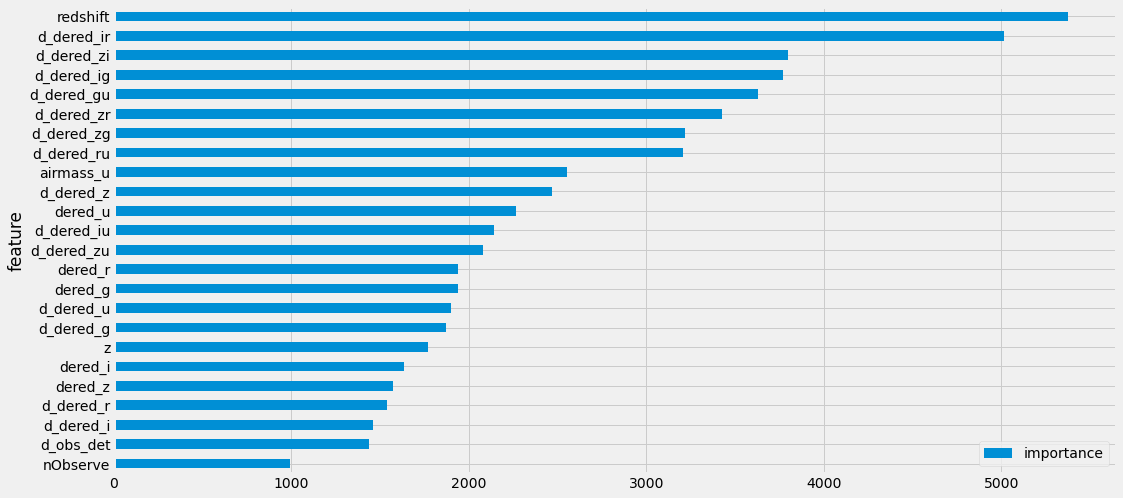

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    40737
0    29976
1     9287
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)